# An exploration of the relationship between intelligence and learning

The relationship between brain structure and function has long been a central focus of neuroscientific endeavors. The dataset analyzed in this study consists of features that have been used to assess the ways in which brain size may relate to intelligence. In order to build on this investigation, we would like to examine how intelligence may related to learning. Furthermore, we aim to explore which particular intelligence features might have the greatest impact on learning.

## Load dataset
The dataset includes 40 participants with Full Scale Intelligent Quotient (FSIQ), Verbal Intelligent Quotient (VIQ), and Performance Intelligent Quotient (PIQ) scores. The brain size of each individual was determined through magnetic resonance imaging (MRI). Height and weight for each participant, and gender was specified.

In [1]:
import requests

# The dataset is located in an OSF project. It is downloaded to the 'Original_Data' folder of the project repository.
url = 'https://files.osf.io/v1/resources/6q2ge/providers/osfstorage/5ed41c6bc7568603c02d50e7'
r = requests.get(url, allow_redirects=True)   

open('../Original_Data/brainsize.csv', 'wb').write(r.content)

In [3]:
import os
dirname = os.path.dirname('../Original_Data/')
filename = os.path.join(dirname, 'brainsize.csv')

In [4]:
import pandas as pd

# Load the dataset into a pandas Dataframe
csvfile = (filename)

data = pd.read_csv(csvfile, sep=';', na_values='.', index_col=0)
data.head()

,Gender,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
1,Female,133,132,124,118.0,64.5,816932
2,Male,140,150,124,NaN,72.5,1001121
3,Male,139,123,150,143.0,73.3,1038437
4,Male,133,129,128,172.0,68.8,965353
5,Female,137,132,134,147.0,65.0,951545


## Novel learning metric
This study will focus on a novel learning metric, partY, which is a continuous variable.

### Generate random variable

In [5]:
# Define random seed
import numpy as np

np.random.seed(1234)

In [6]:
# Define gamma continuous random variable
from scipy import stats as sst

g01 = sst.gamma(100)

### Add learning metric to dataset

In [7]:
# Create pandas Series containing partY
partY = pd.Series(g01.rvs(size=data.shape[0], random_state=1234))

# Add series to pandas Dataframe containing brain size data
partY.index = np.arange(1,len(data)+1)
data['partY'] = partY

## Define multiple linear regression model

In order to investigate the relationship between learning and intelligence, we will use the features in the brain size dataset to predict the learning metric, partY. We use oridinary least squares (OLS) to define our multiple linear regression model.

In [8]:
from statsmodels.formula.api import ols

model = ols('partY ~ FSIQ + VIQ + PIQ + MRI_Count + Height + Weight + Gender -1', data).fit()

# Show OLS results for all regressors
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  partY   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     1.314
Date:                Sun, 31 May 2020   Prob (F-statistic):              0.278
Time:                        22:49:08   Log-Likelihood:                -132.96
No. Observations:                  38   AIC:                             281.9
Df Residuals:                      30   BIC:                             295.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Gender[Female]   158.5318     42.400      3.

### Perform F test

In [9]:
# Define design matrix
A = np.identity(len(model.params))
A = A[1:,:]

print(model.f_test(A))

<F test: F=array([[333.59716747]]), p=1.1843527708668696e-26, df_denom=30, df_num=7>


### Perform analysis of variance (ANOVA) test on fitted linear model

In [10]:
from statsmodels.stats.anova import anova_lm

anova_results = anova_lm(model)

print(anova_results)

             df         sum_sq        mean_sq            F        PR(>F)
Gender      2.0  385194.500562  192597.250281  2372.583443  9.375415e-34
FSIQ        1.0       6.339638       6.339638     0.078097  7.818104e-01
VIQ         1.0      71.499072      71.499072     0.880789  3.554808e-01
PIQ         1.0     409.568213     409.568213     5.045424  3.220840e-02
MRI_Count   1.0      45.128207      45.128207     0.555929  4.617075e-01
Height      1.0      49.354768      49.354768     0.607996  4.416520e-01
Weight      1.0      56.151184      56.151184     0.691720  4.121514e-01
Residual   30.0    2435.285269      81.176176          NaN           NaN


We can see from the p-value generated by the F test above that we have achieved a significant result (p=1.184e-26) for regression to predict partY from the brain size dataset. Based on this result, we can conclude that there is some relationship between partY and this combination of regressors. By examining the details of the ANOVA results, however, we observe that there does not appear to be a significant contribution from any of the intelligence scores, which are assumed to be a more direct measure of intelligence.

### Examine effect of individual regressors
We can use a partial regression plot to assess the relationship of partY to individual regressors conditional on the other dependent variables. This will allow us to determine whether we might be able to remove any features that do not provide much information for the prediction of partY.

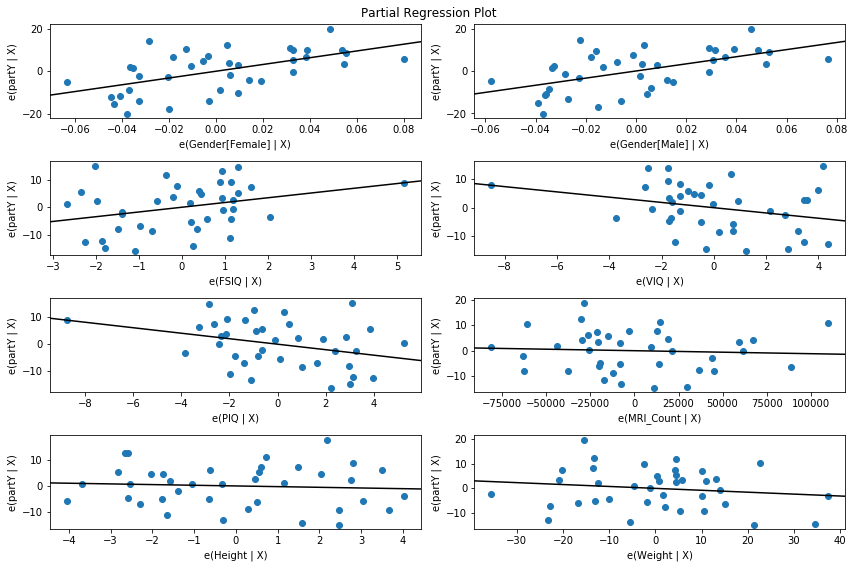

In [11]:
from statsmodels.graphics.api import plot_partregress_grid
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8))
fig = plot_partregress_grid(model, fig=fig)

Partial regression demonstrates that MRI_Count, Height, and Weight do not add much information to the model. MRI_Count is a measure of brain size, which may or may not contribute to intelligence. Height and Weight, moreover, are measures of physical size which may or may not contribute to brain size. We test the importance of these features by defining a new model composed only of intelligence scores and gender.

## Multiple linear regression without brain size features

In [12]:
model_no_brainsize = ols('partY ~ FSIQ + VIQ + PIQ + Gender -1', data).fit()

# Show OLS results for all regressors
print(model_no_brainsize.summary())

                            OLS Regression Results                            
Dep. Variable:                  partY   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     1.875
Date:                Sun, 31 May 2020   Prob (F-statistic):              0.137
Time:                        22:49:09   Log-Likelihood:                -141.33
No. Observations:                  40   AIC:                             292.7
Df Residuals:                      35   BIC:                             301.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Gender[Female]   123.3500     11.196     11.

### Perform F test

In [13]:
# Define design matrix
A = np.identity(len(model_no_brainsize.params))
A = A[1:,:]

print(model_no_brainsize.f_test(A))

<F test: F=array([[660.65835185]]), p=1.9829627250962393e-32, df_denom=35, df_num=4>


### Perform ANOVA

In [14]:
anova_results = anova_lm(model_no_brainsize)

print(anova_results)

            df         sum_sq        mean_sq            F        PR(>F)
Gender     2.0  402973.851587  201486.925794  2569.485359  1.069723e-38
FSIQ       1.0      19.923499      19.923499     0.254077  6.173775e-01
VIQ        1.0      23.338030      23.338030     0.297621  5.888380e-01
PIQ        1.0     477.283960     477.283960     6.086619  1.865907e-02
Residual  35.0    2744.534963      78.415285          NaN           NaN


### Compare to initial model

In [15]:
model.compare_f_test(model_no_brainsize)

(0.7619223044497411, 0.5843654621389822, 5.0)

The F test p-value shows that this model is even more significant for regression to partY. The improvement in model performance is confirmed by comparing the F test of this model to that of the initial model. Again, however, the ANOVA results do not indicate that much information is added to the model from the intelligence scores. Rather, the model appears to be largely driven by Gender. We test the important of Genter for the prediction of partY by defining a third model composed only of intelligence scores.

## Multiple linear regression without gender features

In [16]:
model_no_gender = ols('partY ~ FSIQ + VIQ + PIQ -1', data).fit()

# Show OLS results for all regressors
print(model_no_gender.summary())

                                 OLS Regression Results                                
Dep. Variable:                  partY   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                              396.2
Date:                Sun, 31 May 2020   Prob (F-statistic):                    3.69e-28
Time:                        22:49:09   Log-Likelihood:                         -171.27
No. Observations:                  40   AIC:                                      348.5
Df Residuals:                      37   BIC:                                      353.6
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Perform F test

In [17]:
# Define design matrix
A = np.identity(len(model_no_gender.params))
A = A[1:,:]

print(model_no_gender.f_test(A))

<F test: F=array([[13.60665488]]), p=3.721074537843464e-05, df_denom=37, df_num=2>


### Perform ANOVA

In [18]:
anova_results = anova_lm(model_no_gender)

print(anova_results)

            df         sum_sq        mean_sq            F        PR(>F)
FSIQ       1.0  384952.527551  384952.527551  1161.261213  1.513181e-29
VIQ        1.0     995.122013     995.122013     3.001920  9.149517e-02
PIQ        1.0    8025.959772    8025.959772    24.211390  1.802923e-05
Residual  37.0   12265.322702     331.495208          NaN           NaN


### Compare to model without brain size features

In [19]:
model_no_brainsize.compare_f_test(model_no_gender)

(60.70747420067677, 4.1813960111272385e-12, 2.0)

The F test p-value for the prediction of partY is less significant than the previous two models, but it is still well below the conventional threshold of p=0.05. A comparison of F tests shows that this model improves the significance of regression compared to the model for which only brain size features were removed.

### Examine effect of individual regressors
We can now assess the regression of each intelligence score.

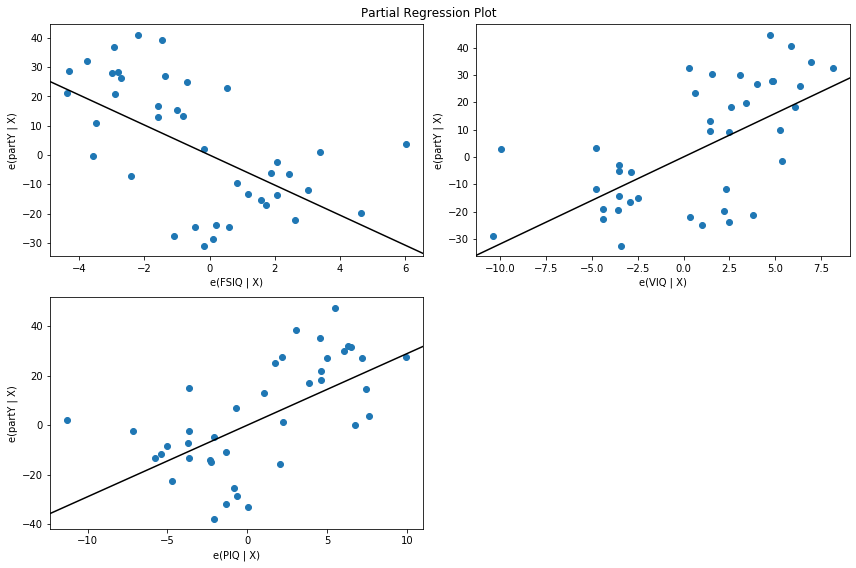

In [27]:
fig = plt.figure(figsize=(12,8))
fig = plot_partregress_grid(model_no_gender, fig=fig)

Тhe partial regression plots for the three intelligence scores confirm an increase in the effect of these scores on the prediction of partY/

### Plot regression plots for FSIQ
FSIQ appears to have a stronger effect on the regression than either VIQ or PIQ. We can investigate the regression of FSIQ in more detail with `plot_regress_exog`.

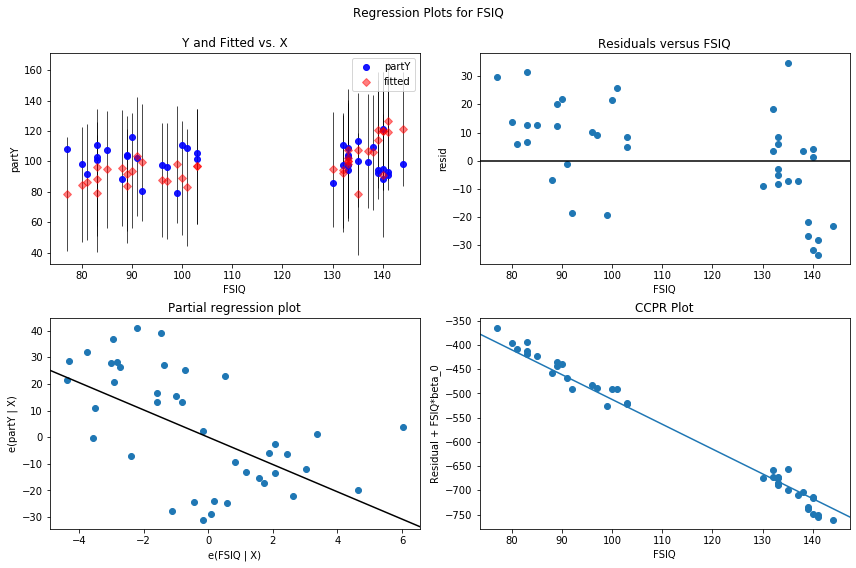

In [28]:
from statsmodels.graphics.api import plot_regress_exog

fig = plt.figure(figsize=(12,8))
fig = plot_regress_exog(model_no_gender, "FSIQ", fig=fig)


A comparison of the partial regression with the CCPR plot demonstrates contribution of FSIQ to the regression without and with the addition of the other independent variables, respectively. We can conclude from these results that while FSIQ contributes more to the regression than VIQ or PIQ, the regression is more significant for a combination of all three scores rather than for FSIQ alone.

## Test MLR model on second learning metric
The MLR model will be used to evaluate the ability of the intelligence scores to predict a second learning metric, partY2.

### Generate random variable

In [22]:
# Define random seed
import numpy as np

np.random.seed(4321)

### Add learning metric to dataset

In [23]:
# Create pandas Series containing partY
partY2 = pd.Series(g01.rvs(size=data.shape[0], random_state=4321))

# Add series to pandas Dataframe containing brain size data
partY2.index = np.arange(1,len(data)+1)
data['partY2'] = partY2

### Perform multiple linear regression

In [24]:
model_no_gender_partY2 = ols('partY2 ~ FSIQ + VIQ + PIQ -1', data).fit()

# Show OLS results for all regressors
print(model_no_gender_partY2.summary())

                                 OLS Regression Results                                
Dep. Variable:                 partY2   R-squared (uncentered):                   0.971
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                              411.6
Date:                Sun, 31 May 2020   Prob (F-statistic):                    1.86e-28
Time:                        22:49:11   Log-Likelihood:                         -170.30
No. Observations:                  40   AIC:                                      346.6
Df Residuals:                      37   BIC:                                      351.7
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Perform F test

In [25]:
# Define design matrix
A = np.identity(len(model_no_gender_partY2.params))
A = A[1:,:]

print(model_no_gender_partY2.f_test(A))

<F test: F=array([[22.18720355]]), p=4.652719860998372e-07, df_denom=37, df_num=2>


### Perform ANOVA

In [26]:
anova_results = anova_lm(model_no_gender_partY2)

print(anova_results)

            df         sum_sq        mean_sq            F        PR(>F)
FSIQ       1.0  375985.871175  375985.871175  1190.331353  9.708333e-30
VIQ        1.0     313.265923     313.265923     0.991767  3.257796e-01
PIQ        1.0   13703.125459   13703.125459    43.382640  1.013930e-07
Residual  37.0   11687.062767     315.866561          NaN           NaN


These results demonstrate that the regression is significant for the prediction of partY2. The study thus concludes that a relationship exists between intelligence and learning.